In [1]:
import numpy  as np
import pandas as pd
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch

In [2]:
#读入训练集标签
train_df = pd.read_csv('../input/train.csv')
test_df  = pd.read_csv('../input/sample_submission.csv')

In [3]:
#读入数据，制作成fastai数据集
test_img = ImageList.from_df(test_df, path='../input/test', folder='test')
trans = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
train_img = (ImageList.from_df(train_df, path='../input/train', folder='train')
.split_by_rand_pct(0.01)
.label_from_df()
.add_test(test_img)
.transform(trans, size=128)
.databunch(path='.', bs=64, device=torch.device('cuda:0'))
.normalize(imagenet_stats))


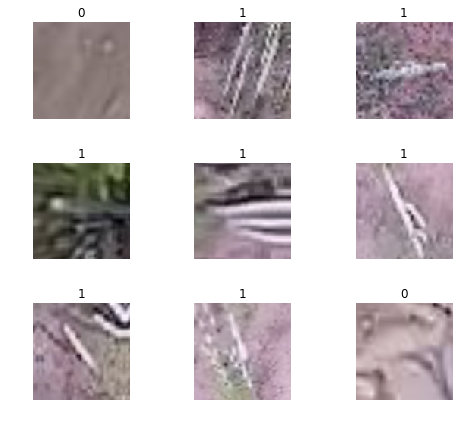

In [4]:
train_img.show_batch(rows=3, figsize=(7,6))

In [5]:
learn = cnn_learner(train_img, models.densenet161, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:01, 83758001.26it/s]


In [6]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


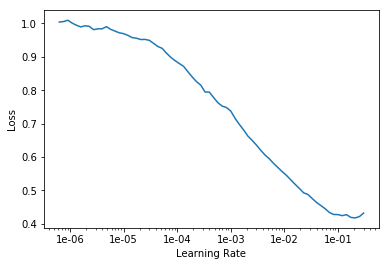

In [7]:
learn.recorder.plot()

In [8]:
lr = 3e-02
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.046771,0.009250,0.005714,0.994286,01:13
1,0.084661,0.000044,0.000000,1.000000,01:08
2,0.029866,0.000088,0.000000,1.000000,01:08
3,0.010029,0.001374,0.000000,1.000000,01:07
4,0.004366,0.000017,0.000000,1.000000,01:07


In [9]:
#learn.unfreeze()
#learn.lr_find()
#learn.recorder.plot()

In [10]:
#learn.fit_one_cycle(1, slice(1e-06))

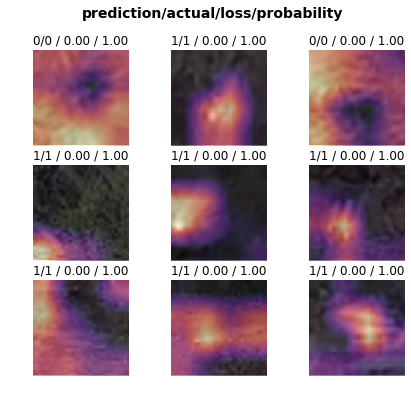

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(7,6))

In [12]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)

In [13]:
test_df.has_cactus = preds.numpy()[:, 0]

In [14]:
test_df.to_csv('submission.csv', index=False)